In [1]:
!pip install -U ultralytics opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 123.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.18.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.8 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.


In [2]:
from ultralytics import YOLO
import os, cv2, glob, random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
CLASSES = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}


In [4]:
def voc_to_yolo(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    labels = []

    for obj in root.findall("object"):
        cls = obj.find("name").text
        if cls not in CLASSES:
            continue

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        x_c = ((xmin + xmax) / 2) / img_w
        y_c = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        labels.append(f"{CLASSES[cls]} {x_c} {y_c} {w} {h}")

    return labels


In [5]:
BASE = "/kaggle/input/face-mask-detection"
OUT = "/kaggle/working/mask_yolo"

for split in ["train", "val", "test"]:
    os.makedirs(f"{OUT}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT}/labels/{split}", exist_ok=True)


In [6]:
images = sorted(glob.glob(f"{BASE}/images/*.png"))
random.shuffle(images)

n = len(images)
train, val, test = images[:int(.7*n)], images[int(.7*n):int(.85*n)], images[int(.85*n):]

def process(split_imgs, split):
    for img_path in split_imgs:
        name = os.path.basename(img_path)
        xml = f"{BASE}/annotations/{name.replace('.png','.xml')}"

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        labels = voc_to_yolo(xml, w, h)
        if not labels:
            continue

        cv2.imwrite(f"{OUT}/images/{split}/{name}", img)
        with open(f"{OUT}/labels/{split}/{name.replace('.png','.txt')}", "w") as f:
            f.write("\n".join(labels))

process(train, "train")
process(val, "val")
process(test, "test")


In [7]:
# ================================
# DATASET SANITY CHECK (ADD HERE)
# ================================
import cv2
import glob
import os

def check_images(img_dir):
    bad = []
    for img_path in glob.glob(f"{img_dir}/*"):
        img = cv2.imread(img_path)
        if img is None:
            bad.append(img_path)
    return bad

bad_train = check_images("/kaggle/working/mask_yolo/images/train")
bad_val   = check_images("/kaggle/working/mask_yolo/images/val")

print("Bad train images:", len(bad_train))
print("Bad val images:", len(bad_val))


Bad train images: 0
Bad val images: 0


In [8]:
# ================================
# REMOVE CORRUPTED FILES (ADD HERE)
# ================================
def remove_bad(bad_imgs):
    for img in bad_imgs:
        label = img.replace("images", "labels").replace(".png", ".txt")
        if os.path.exists(img):
            os.remove(img)
        if os.path.exists(label):
            os.remove(label)

remove_bad(bad_train)
remove_bad(bad_val)


In [9]:
yaml_content = f"""
path: {OUT}
train: images/train
val: images/val

names:
  0: with_mask
  1: without_mask
  2: mask_weared_incorrect
"""
open("mask.yaml", "w").write(yaml_content)


137

In [10]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")   # lightweight + real-time

model.train(
    data="mask.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,

    # 🔴 CRITICAL FIXES
    amp=False,              # Disable AMP to avoid OpenCV resize crash
    deterministic=False,    # Avoid AMP + deterministic conflict

    # Optimizer & augmentation
    optimizer="AdamW",
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.0,
    fliplr=0.5,
    scale=0.5,
    mosaic=1.0,

    # Stability (recommended)
    workers=4,
    patience=10
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=mask.yaml, degrees=0.0, deterministic=False, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pre

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bd7d2925940>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [11]:
metrics = model.val(iou=0.5)
print(metrics)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2229.1±754.1 MB/s, size: 180.7 KB)
val: Scanning /kaggle/working/mask_yolo/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 244.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.6it/s 3.0s0.2ss
                   all        128        601      0.728      0.715      0.771      0.495
             with_mask        116        471      0.883      0.916      0.936      0.643
          without_mask         46        109      0.802      0.708      0.826      0.503
 mask_weared_incorrect         16         21      0.498       0.52      0.551       0.34
Speed: 1.7ms preprocess, 10.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/workin


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss188.png: 640x512 1 with_mask, 41.2ms
Speed: 3.8ms preprocess, 41.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


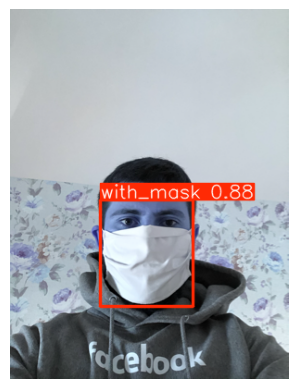


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss705.png: 384x640 23 with_masks, 83.6ms
Speed: 2.1ms preprocess, 83.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


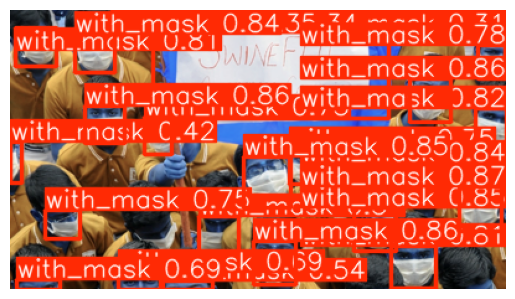


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss827.png: 640x512 1 with_mask, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


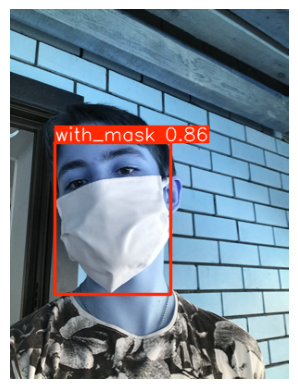


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss686.png: 640x512 1 with_mask, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


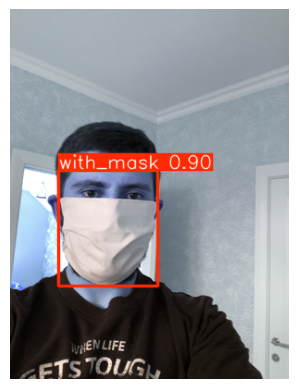


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss653.png: 384x640 3 with_masks, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


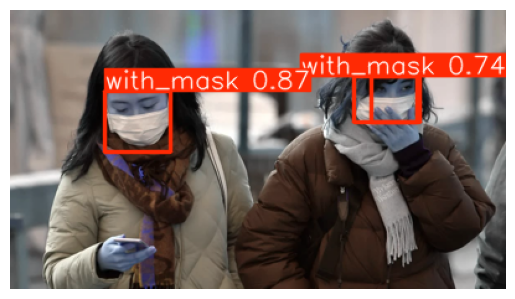


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss190.png: 480x640 1 with_mask, 41.1ms
Speed: 1.9ms preprocess, 41.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


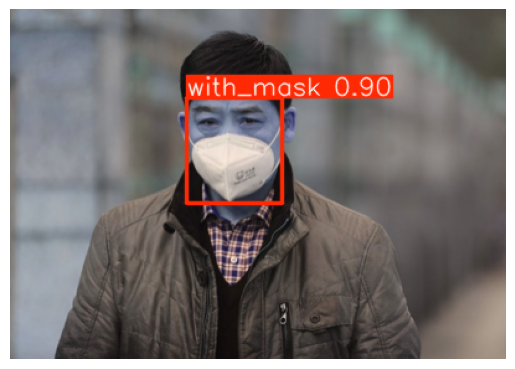


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss595.png: 448x640 6 with_masks, 44.0ms
Speed: 1.9ms preprocess, 44.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


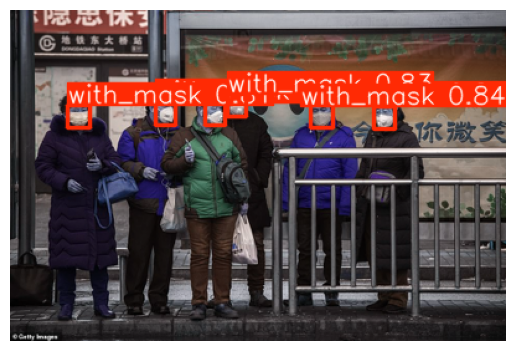


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss329.png: 448x640 9 with_masks, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


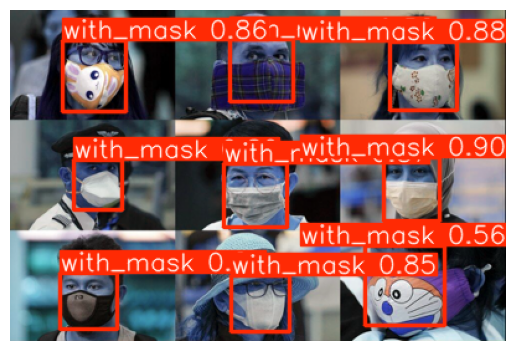


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss254.png: 352x640 8 with_masks, 2 without_masks, 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


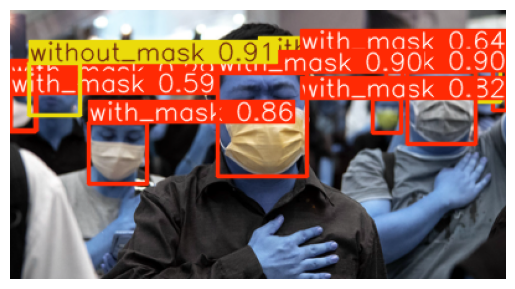


image 1/1 /kaggle/working/mask_yolo/images/test/maksssksksss777.png: 384x640 7 with_masks, 1 without_mask, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


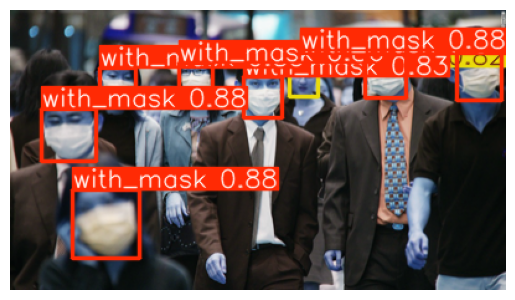

In [12]:
test_imgs = glob.glob(f"{OUT}/images/test/*.png")
sample = random.sample(test_imgs, 10)

for img_path in sample:
    results = model(img_path)
    annotated = results[0].plot()
    plt.imshow(annotated)
    plt.axis("off")
    plt.show()


In [14]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
metrics = model.val(data="mask.yaml", iou=0.5)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3328.2±707.4 MB/s, size: 171.6 KB)
val: Scanning /kaggle/working/mask_yolo/labels/val.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 264.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.9it/s 2.8s0.4s
                   all        128        601      0.728      0.715      0.771      0.495
             with_mask        116        471      0.883      0.916      0.936      0.643
          without_mask         46        109      0.802      0.708      0.826      0.503
 mask_weared_incorrect         16         21      0.498       0.52      0.551       0.34
Speed: 2.4ms preprocess, 9.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss689.png: 384x640 1 with_mask, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


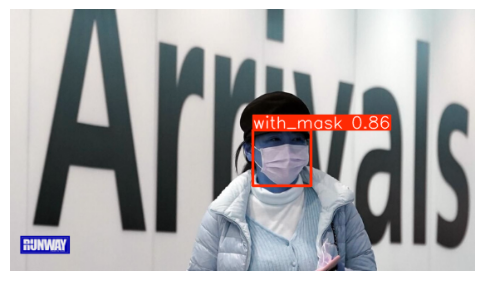


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss703.png: 448x640 8 with_masks, 3 without_masks, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


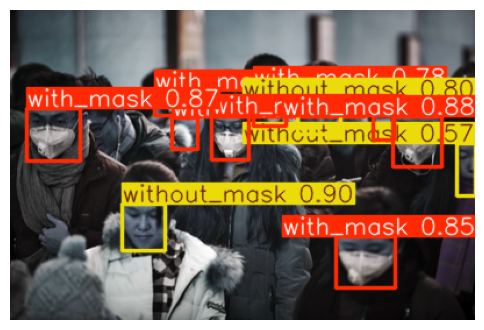


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss496.png: 640x448 (no detections), 43.1ms
Speed: 1.8ms preprocess, 43.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


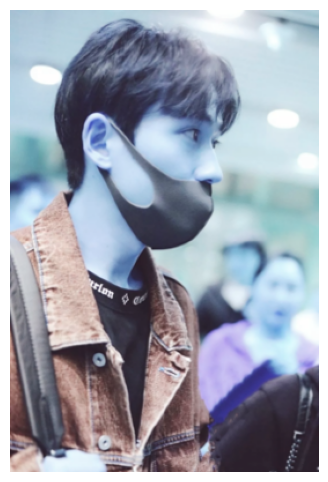


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss105.png: 448x640 9 with_masks, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


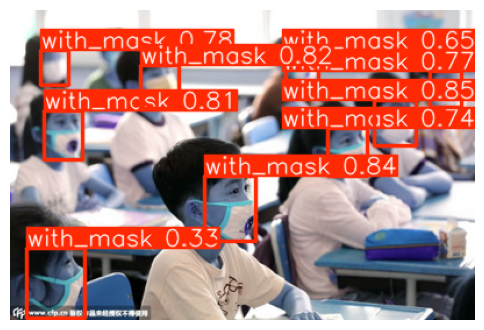


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss355.png: 640x512 1 with_mask, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


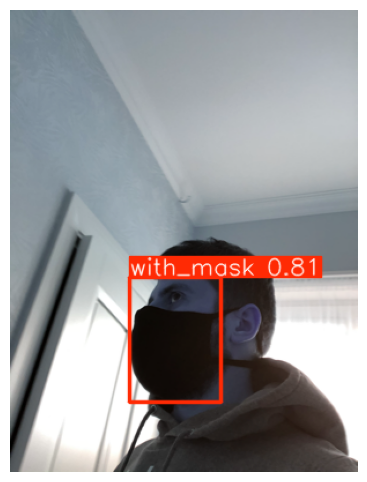


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss667.png: 384x640 3 with_masks, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


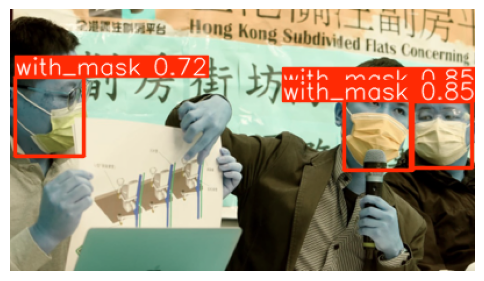


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss749.png: 640x416 2 with_masks, 42.2ms
Speed: 1.7ms preprocess, 42.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


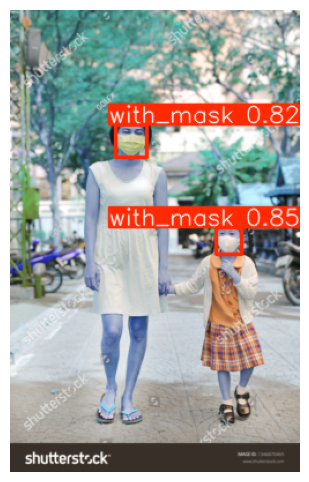


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss183.png: 384x640 4 with_masks, 3 without_masks, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


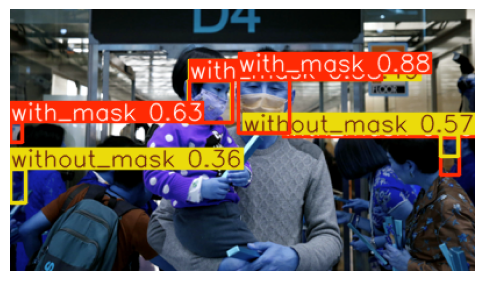


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss554.png: 480x640 5 with_masks, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


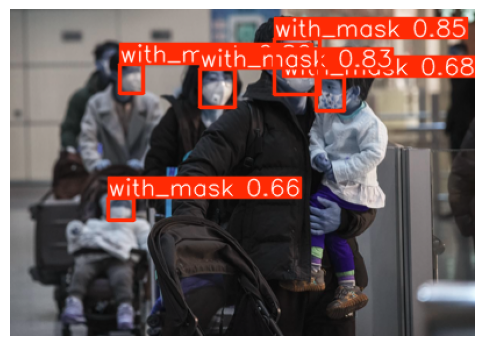


image 1/1 /kaggle/working/mask_yolo/images/val/maksssksksss767.png: 640x448 1 with_mask, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


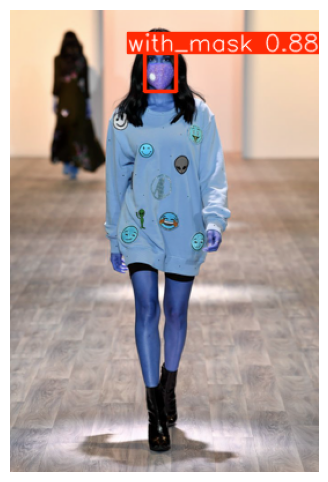

In [15]:
import random, glob, matplotlib.pyplot as plt

test_images = glob.glob("/kaggle/working/mask_yolo/images/val/*.png")

for img in random.sample(test_images, 10):
    result = model(img)[0]
    plt.figure(figsize=(6,6))
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()
